# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras.python.keras.utils.io_utils import HDF5Matrix
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Activation
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

In [13]:
with h5py.File('/data/joint_scoring/labels_train_regression.h5', 'r') as hf:
    labels_train = hf['labels_train_regression'][:]

def round_x(x, base=5):
    return int(base * round(float(x)/base))
    
labels_train_rounded = [ round_x(x) for x in labels_train ]

classes = np.unique(labels_train_rounded)

# define class weights because of imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                 classes=classes, 
                                                 y=labels_train_rounded)

print(max(weights)/min(weights))

weights = dict(zip(classes, weights))
print(weights)

5428.33333333
{0: 0.07078770511377204, 65: 64.043209876543216, 35: 19.320297951582869, 100: 4.3665824915824913, 5: 0.29950059178430183, 70: 21.614583333333332, 40: 7.3738450604122248, 10: 0.63830441737418486, 75: 138.33333333333334, 45: 30.336257309941519, 15: 2.5133236434108528, 80: 22.456709956709958, 50: 10.90956887486856, 20: 2.087105210219272, 85: 111.55913978494624, 55: 58.61581920903955, 25: 8.3534621578099841, 90: 27.666666666666668, 60: 14.653954802259888, 30: 5.45478443743428, 95: 384.25925925925924}


In [14]:
# model.fit does not work with class_weights for a HDF5 Matrix
# therefore, create sample weights

sample_weights = [ weights[x] for x in labels_train_rounded ]

sample_weights = np.array(sample_weights)

Import data as HDF5 Matrix

In [15]:
img_train = HDF5Matrix('/data/joint_scoring/img_train_regression.h5', 'img_train_regression')
img_test = HDF5Matrix('/data/joint_scoring/img_test_regression.h5', 'img_test_regression')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_regression.h5', 'labels_train_regression')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_regression.h5', 'labels_test_regression')

## 2. Model

In [16]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # Compile model
    model.compile(optimizer="adam", loss="mean_squared_error",
                  metrics=["mae"])

    return model

In [17]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [6]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [7]:
print(new_folder)

20171028_153155


In [8]:
desc = "Regression model on original data"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [9]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [24]:
# Fit the model
model.fit(x=img_train, y=labels_train, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test, labels_test),
          shuffle="batch")

Train on 72625 samples, validate on 19709 samples
Epoch 1/25
72625/72625 [==============================] - 188s - loss: 170.3552 - mean_absolute_error: 4.9649 - val_loss: 152.4259 - val_mean_absolute_error: 4.8305
Epoch 2/25
72625/72625 [==============================] - 181s - loss: 154.4028 - mean_absolute_error: 4.9731 - val_loss: 144.1160 - val_mean_absolute_error: 5.3793
Epoch 3/25
72625/72625 [==============================] - 179s - loss: 140.1580 - mean_absolute_error: 4.9688 - val_loss: 124.1918 - val_mean_absolute_error: 4.8972
Epoch 4/25
72625/72625 [==============================] - 178s - loss: 127.0507 - mean_absolute_error: 4.9562 - val_loss: 114.2044 - val_mean_absolute_error: 4.9947
Epoch 5/25
72625/72625 [==============================] - 177s - loss: 115.9126 - mean_absolute_error: 4.9396 - val_loss: 135.0915 - val_mean_absolute_error: 4.8110
Epoch 6/25
72625/72625 [==============================] - 177s - loss: 105.3560 - mean_absolute_error: 4.9111 - val_loss: 105

In [25]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print(scores)

[81.939261736321342, 4.5450772834372151]


In [26]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [27]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
pred = model.predict_classes(img_test)

print(explained_variance_score(labels_test, pred))
print(mean_absolute_error(labels_test, pred))
print(r2_score(labels_test, pred))


19680/19709 [============================>.] - ETA: 0s0.0018627356334
5.43873357349
-0.0806372129


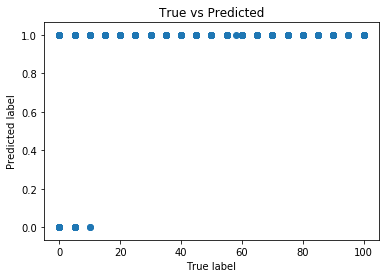

In [28]:
plt.title("True vs Predicted")
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.scatter(x=labels_test, y=pred)

plt.show()

In [30]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_regression_weights.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)